# Estimating technical noise

To start, we will load a few modules, namely scLVM and the rpy2 module allowing us to call R code from wihtin the notebook.

In [1]:
from scLVM import scLVM
from scLVM.utils.barplot import *
from scLVM.utils.misc import *
import scipy as SP
import pandas as pd
from matplotlib import cm
%load_ext rpy2.ipython

# activiate inline plotting
%pylab inline

/Users/flo/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Populating the interactive namespace from numpy and matplotlib


First, we load some util files which are part of the scLVM R package, normalise the expression data and call the variable genes.

In [14]:
%%R
source('/Users/flo/projects/Auto_Bionf/scLVM2/py/demo/ipynb/util.R')
load('/Users/flo/projects/Auto_Bionf/scLVM2/py/demo/ipynb/data_Tcells.rda')
#source('/Users/stegle/research/scLVM-tutorials/util.R')
#load('/Users/stegle/research/scLVM-tutorials/scLVM/data/data_Tcells.rda')
#library(scLVM)
#data(data_Tcells)
print(dataMouse[ 1:5, 1:4 ])
print(dim(dataMouse))

geneTypes <- factor( c( ENSM="ENSM", ERCC="ERCC" )[
  substr( rownames(dataMouse), 1, 4 ) ] )

#2. calculate normalisation for counts
countsMmus <- dataMouse[ which( geneTypes=="ENSM" ), ]
countsERCC <- dataMouse[ which( geneTypes=="ERCC" ), ]
lengthsMmus <- dataMouse[ which( geneTypes=="ENSM" ), 1 ]
lengthsERCC <- dataMouse[ which( geneTypes=="ERCC" ), 1 ]

#we use the size factor calcluated from ERCCs for both ERCCs and endogenous genes to 
#only correct for sequencing depth and retain information on cell size
sfERCC <- estimateSizeFactorsForMatrix( countsERCC )
sfMmus <- sfERCC #also use ERCC size factor for endogenous genes


#normalise read counts
nCountsERCC <- t( t(countsERCC) / sfERCC )
nCountsMmus <- t( t(countsMmus) / sfERCC )

                   X9108_01.txt X9108_02.txt X9108_03.txt X9108_04.txt
ENSMUSG00000000001         1678           21          409         1780
ENSMUSG00000000003            0            0            0            0
ENSMUSG00000000028         1556            1         3192            2
ENSMUSG00000000031            0            0            0            0
ENSMUSG00000000037            0            0            2            0
[1] 38385    81


We can now plot some basic QC measure to check 
* Total library size
* Library size of endogenous genes
* Library size of ERCC spike-ins
* Ratio of ERCC spike-ins over total mapped reads

Q: What is the latter a measure for?


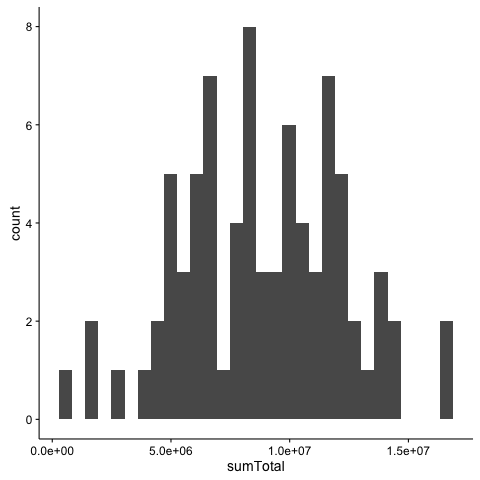

In [27]:
%%R
library(cowplot)
sumERCC = apply(countsERCC,2,sum)
sumMmus = apply(countsMmus,2,sum)
sumTotal = sumERCC + sumMmus
ggplot(data.frame(sumTotal), aes(x=sumTotal))+geom_histogram()

#you code here: repeat for 
#* Library size of endogenous genes
#* Library size of ERCC spike-ins
#* Ratio of ERCC spike-ins over total mapped reads

Using the normalised read counts and the ERCC spike-ins, we can estimate the technical noise by fitting the relationship between mean and squared coefficient of variation (CV2) following Brennecke et al.

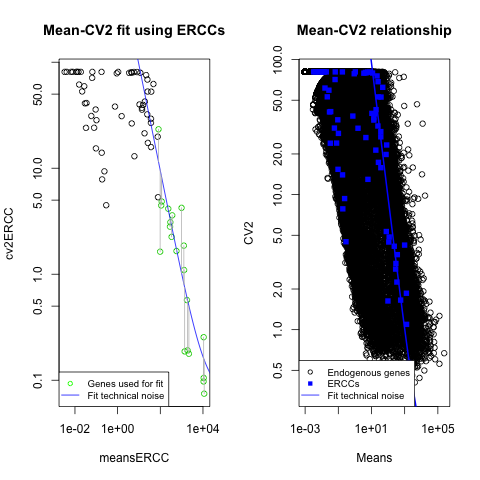

In [4]:
%%R 
techNoise = fitTechnicalNoise(nCountsMmus,nCountsERCC=nCountsERCC, fit_type = 'counts')

If no spike-ins are available, we can also use the endogenous read counts for fitting the mean-CV2 relation using a log-linear fit in the log-space. Alternatively, we can fit the mean-variance relationship in the log-space using local 2nd order polynomial regression (loess).

In [5]:
%%R
#Your code here
techNoiseLogFit = fitTechnicalNoise(nCountsMmus, fit_type = 'log', use_ERCC = FALSE, plot=FALSE) 

techNoiseLogVarFit = fitTechnicalNoise(nCountsMmus, fit_type = 'logvar', use_ERCC = FALSE, plot=FALSE)

Once we have completed the fitting process, we can call variable genes.

/Users/flo/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in points(meansERCC, cv2ERCC, pch = 20, cex = 1, col = "blue") : 
  Objekt 'meansERCC' nicht gefunden

  res = super(Function, self).__call__(*new_args, **new_kwargs)



FALSE  TRUE 
23160  7073 
[1] "No 'fit_type' specified. Trying to guess its from parameter names"
[1] "Assuming 'fit_type' is 'log'"
[1] "No 'fit_type' specified. Trying to guess its from parameter names"
[1] "Assuming 'fit_type' is 'logvar'"
[1] 7099
is_hetLogVar
FALSE  TRUE 
31194  7099 


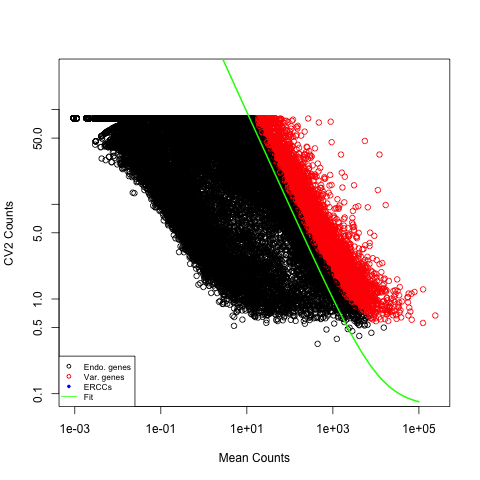

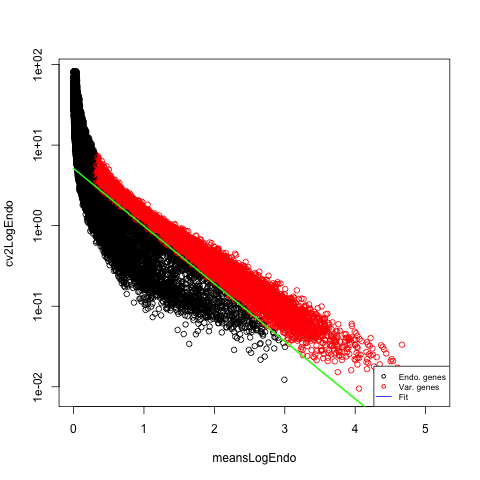

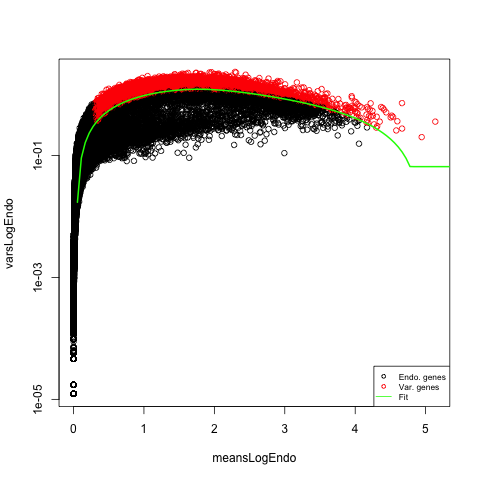

In [6]:
%%R
#call variable genes
is_het = getVariableGenes(nCountsMmus, techNoise$fit, method = "fdr", 
                          threshold = 0.1, fit_type="counts",sfEndo=sfMmus, sfERCC=sfERCC)
table(is_het)

#we an also do this for the other fits - how similar are the sets of recovered genes?
#Your code here
is_hetLog = getVariableGenes(nCountsMmus, techNoiseLogFit$fit, plot=TRUE)
table(is_hetLog)

is_hetLogVar = getVariableGenes(nCountsMmus, techNoiseLogVarFit$fit, plot=TRUE)
table(is_hetLogVar)

# scLVM  - Single cell latent variable model to remove cell-cycle effects

In order to fit the latent cell cycle factor we need to retrieve cell cycle genes. For illustration purposes, here we only use genes annotated in GO (term GO:0007049). We then pass the data required to run scLVM to python. These include:

* First, the required data have to be loaded. These include:
* Normalised gene expression data: LogNcountsMmus
* Technical noise (in log space): LogVar_techMmus
* Gene symbols: gene_names
* Heterogeneous genes (boolean vector): genes_geterogen
* Cell cycle genes: cellcyclegenes_filter

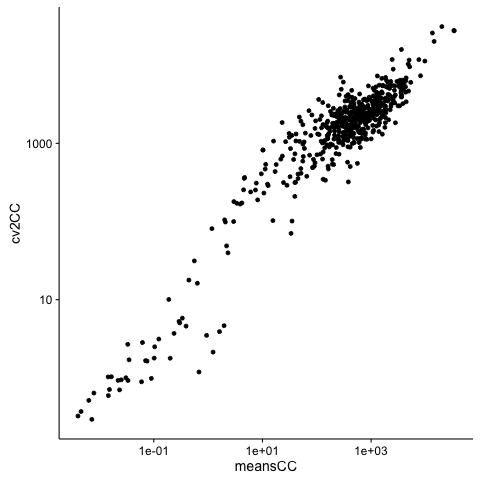

In [31]:
%%R -o ens_ids_cc,Y,genes_het_bool,tech_noise,idx_cc,geneID
#get cell cycle genes from GO 
ens_ids_cc <- getEnsembl('GO:0007049')
Y = t(log10(nCountsMmus+1)) #normalised trandformed read counts
genes_het_bool = as.vector(is_het) #variable genes
geneID = rownames(nCountsMmus) #gene IDs
tech_noise = as.vector(techNoise$techNoiseLog) #technical noise
idx_cc = na.omit(match(ens_ids_cc,geneID))-1 #cc indices in python indexing

#your code here: Can you plot the mean expression vs coefficient of variation of the set of cell cycle genes? 
#Compare this to a set of differentiation genes (GO:0045064)
meansCC = apply(nCountsMmus[idx_cc+1,],1,mean)
cv2CC = apply(nCountsMmus[idx_cc+1,],1,var)/meansCC
qplot(meansCC,cv2CC)+scale_y_log10()+scale_x_log10()


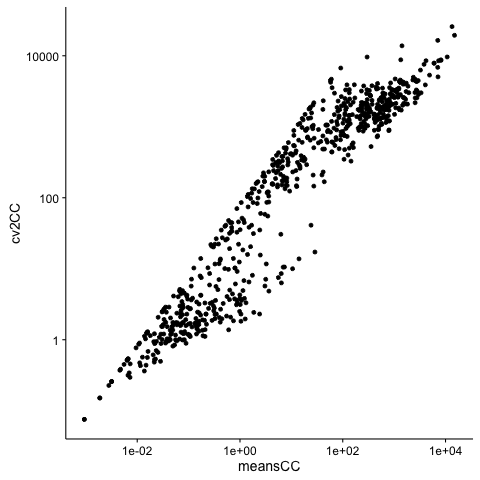

In [34]:
#your code here: Can you plot the mean expression vs coefficient of variation of the set of cell cycle genes? 
#Compare this to a set of differentiation genes (GO:0045064)
%%R
ens_ids_cc <- getEnsembl('GO:0030154')
idx_cc = na.omit(match(ens_ids_cc,geneID))-1 #cc indices in python indexing

meansCC = apply(nCountsMmus[idx_cc+1,],1,mean)
cv2CC = apply(nCountsMmus[idx_cc+1,],1,var)/meansCC
qplot(meansCC,cv2CC)+scale_y_log10()+scale_x_log10()

Filter out genes with zero expression in all cells and visualise the cell cycle matrix.`

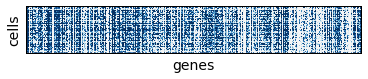

In [9]:
#your code here

idx_nonzero = SP.where((Y.mean(0)**2)>0)[0]
idx_cc_filtered = SP.intersect1d(idx_cc.astype('int32'),idx_nonzero)
Ycc = Y[:,idx_cc_filtered]
plt = PL.subplot(1,1,1)
PL.imshow(Ycc,cmap=cm.RdBu,vmin=-3,vmax=+3,interpolation='None')
#PL.colorbar()
plt.set_xticks([])
plt.set_yticks([])
PL.xlabel('genes')
PL.ylabel('cells')

scLVM can now be fit using the cell cycle expression matrix. The user needs to define the number of latent factors to be fitted. Initially, we fit a model assuming a large numbers of factos:

In [8]:
k = 80                    # number of latent factors
out_dir = './cache'       # folder where results are cached
file_name = 'Kcc.hdf5'    # name of the cache file
recalc = True             # recalculate X and Kconf
use_ard = True            # use automatic relevance detection
sclvm = scLVM(Y)
#Fit model with 80 factors
X_ARD,Kcc_ARD,varGPLVM_ARD = sclvm.fitGPLVM(idx=idx_cc_filtered,k=k,out_dir=out_dir,file_name=file_name,recalc=recalc, use_ard=use_ard)


In order to determine an appropriate number of hidden factors, it is instructive to visualize the variance contributions of the individual latent factors.

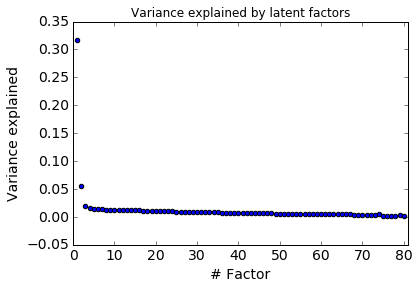

In [9]:
#Plot variance contributions from ARD 
plt = PL.subplot(1,1,1)
PL.title('Variance explained by latent factors')
PL.scatter(SP.arange(k)+1,varGPLVM_ARD['X_ARD'])
PL.xlim([0,k+1])
PL.xlabel('# Factor')
PL.ylabel('Variance explained')

In this example (and generally when considering cell cycle as the confounding factor), there is a large gap in the proportion of explained variance between the first and the second factor. This suggests, that a single latent factor underlies the variation captured by the cellcycle genes. Consequently, we choose to re-fit the scLVM mdoel with one latent factor only.

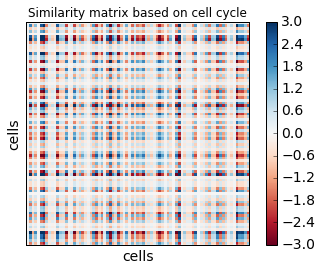

In [10]:
X,Kcc,varGPLVM = sclvm.fitGPLVM(idx=idx_cc_filtered,k=1,out_dir='./cache',file_name=file_name,recalc=True, use_ard=False)

#Plot inferred similarity matrix
plt = PL.subplot(1,1,1)
PL.title('Similarity matrix based on cell cycle')
PL.imshow(Kcc,cmap=cm.RdBu,vmin=-3,vmax=+3,interpolation='None')
PL.colorbar()
plt.set_xticks([])
plt.set_yticks([])
PL.xlabel('cells')
PL.ylabel('cells')

# Variance decomposition and cell cycle correction

First, we use the fitted scLVM model to decompose the source of variance for each gene.


In [11]:
# considers only heterogeneous genes
Ihet = genes_het_bool==1
Y    = Y[:,Ihet]
tech_noise = tech_noise[Ihet]
geneID = geneID[Ihet]

The computation time for the next step can be substantial. If large datasets are considerd, it may be advisable to distribute these calculations on a high performance compute cluster. In this case i0 and i1 determine the range of genes for wich this anlaysis is performed. Here, we fit the model on 1,000 genes only in order to limit computation times. Consequently, all the downstram analyses illustrated in this notebook are done on a subset of all variable genes only. For large datasets we recommend using the extended version of scLVM, fscLVM, which is available on pip. The accompanying paper is currently in revision.

In [12]:
#optionally: restrict range for the analysis
i0 = 0    # gene from which the analysis starts
i1 = 1000 # gene at which the analysis ends 

# construct sclvm object
sclvm = scLVM(Y,geneID=geneID,tech_noise=tech_noise)

# fit the model from i0 to i1
sclvm.varianceDecomposition(K=Kcc,i0=i0,i1=i1)

Once the contribution of cell cycle to the observed variance is estimated, cell-cycle corrected gene expression levels can be obtained. The variance component estimates calculated by scLVM are normalised such that they sum uo to 1. There may be a small number of genes where the maximum likelihood fit does not converge propperly. We suggest to remove these in downstream analyses.

In [7]:
normalize=True    # variance components are normalizaed to sum up to one

# get variance components
var, var_info = sclvm.getVarianceComponents(normalize=normalize)
var_filtered = var[var_info['conv']] # filter out genes for which vd has not converged

# get corrected expression levels
Ycorr = sclvm.getCorrectedExpression()
Ycorr.shape

NameError: name 'sclvm' is not defined


Here, we visualize the resulting variance component using a pie chart. Shown are the average contributions of variance (across genes) for different categories:
* Hidden_0: the first hidden factor, here the the cell cycle
* bio_noise: the residual biological variation
* techh_noise: the technical noise level

Repeat this when the technical noise is estimated without using ERRCs. How do the results differ?

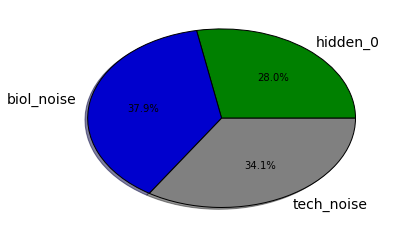

In [14]:
#calculate average variance components across all genes and visualize
var_mean = var_filtered.mean(0)
colors = ['Green','MediumBlue','Gray']
pp=PL.pie(var_mean,labels=var_info['col_header'],autopct='%1.1f%%',colors=colors,
       shadow=True, startangle=0)

We can also visualize this stratifying for different levels of technical noise.

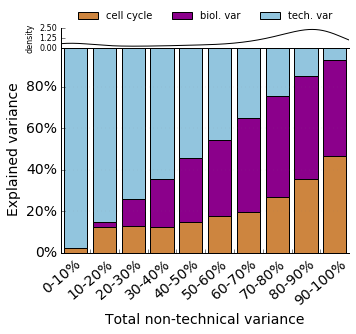

In [15]:
H2=1-var_filtered[:,2]
var_comp_fileds = SP.array([[0, 'cell cycle', 'Peru'],
       [1, 'biol. var', 'DarkMagenta'],
       [2, 'tech. var', '#92c5de']], dtype=object)
var_plot(var_filtered,H2,var_comp_fileds,normalize=True, figsize=[5,4])

# Gene correlation analysis


The fitted cell cycle covariance matrix can also be used in a range of other analyses. Here, we illustrate it's use to improve the estimation of pairwise correlation coefficients between genes, while accounting for the cell cycle. For each gene i, we fit a linear mixed model with a fixed effect representing the contribution of a second gene j and random effect representing the contribution of the cell cycle. Gene correlations can then be determined by testing the significance of the fixed effect. Again, the computational complexity of this analysis can be substantial, requiring distributing these analyses on a parallel compute cluster. For illustration, we here consider the gene-gene correlation network of the first 10 genes.

In [16]:
i0 = 10     # gene from which the analysis starts
i1 = 20    # gene to which the analysis ends

# fit lmm without correction
pv0,beta0,info0 = sclvm.fitLMM(K=None,i0=i0,i1=i1,verbose=False)
# fit lmm with correction
pv1,beta1,info1 = sclvm.fitLMM(K=Kcc,i0=i0,i1=i1,verbose=False)

(<matplotlib.text.Text at 0x12546ba10>, <matplotlib.text.Text at 0x12548e350>)

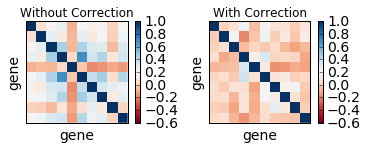

In [17]:
plt=PL.subplot(2,2,1)
PL.title('Without Correction')
p=PL.imshow(beta0[:,i0:i1],cmap=cm.RdBu,vmin=-0.6,vmax=+1,interpolation='None')
PL.colorbar()
plt.set_xticks([])
plt.set_yticks([])
PL.xlabel('gene'),PL.ylabel('gene')
plt=PL.subplot(2,2,2)
PL.title('With Correction')
p=PL.imshow(beta1[:,i0:i1],cmap=cm.RdBu,vmin=-0.6,vmax=+1,interpolation='None')
PL.colorbar()
plt.set_xticks([])
plt.set_yticks([])
PL.xlabel('gene'),PL.ylabel('gene')

The cell-cycle corrected gene expression matix can used for various kinds of downstream analysis. This includes clustering, visualisation, network analysis etc. To use the correct expression matrix in other programmes, it is straightforward to export the corrected expression matrix as CSV file:

In [18]:
SP.savetxt('Ycorr.txt',Ycorr)


As an example for downstream analyses using corrected exprssion levels, we here consider GPy to fit a non-linear Bayeisan PCA model, therbey visualizing hidden substructures between cells.

In [19]:
import GPy
# Model optimization
Ystd = Ycorr-Ycorr.mean(0)
Ystd/=Ystd.std(0)
input_dim = 2 # How many latent dimensions to use
kern = GPy.kern.RBF(input_dim,ARD=True) # ARD kernel
m = GPy.models.BayesianGPLVM(Ystd, input_dim=input_dim, kernel=kern, num_inducing=40)
m.optimize('scg', messages=0, max_iters=2000)

The model assumes two principle components. Here, we visualize the relative importance of the two components.


 /Users/stegle/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


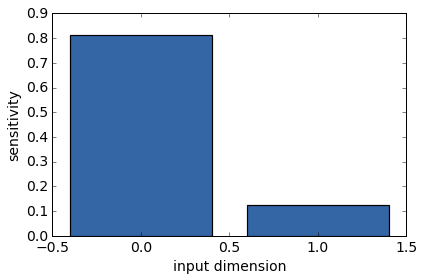

In [20]:
m.kern.plot_ARD()

Finally, the position of individual cells in the principal component space can be visualized. Cells are colour coded by GATA3 expression, a canonical T-cell differentiation marker gene.

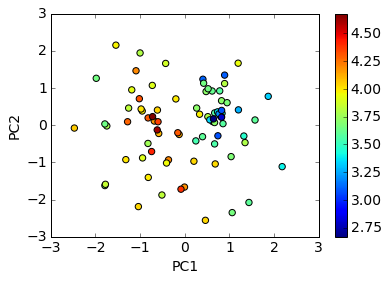

In [21]:
i_Gata3 = SP.where(geneID=='ENSMUSG00000015619')
color = Ycorr[:,i_Gata3]
#color = Ycorr[:,0]
PL.scatter(m.X.mean[:,0], m.X.mean[:,1], 40, color)
PL.xlabel('PC1')
PL.ylabel('PC2')
PL.colorbar()

We comapre the non-linear projection to a standard principle component anlaysis:


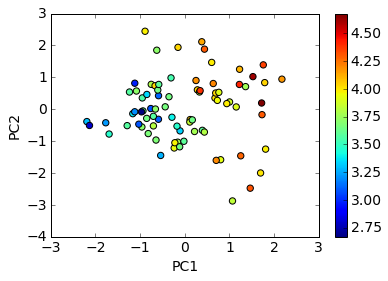

In [22]:
[S,W] = PCA(Ystd,2)
PL.scatter(S[:,0],S[:,1], 40, color)
PL.xlabel('PC1')
PL.ylabel('PC2')
PL.colorbar()

Plot data using alternative dimensionality reduction algorithms. In particular t-SNE is a very poplar choice for visualising single-cell RNA-seq data.

In [23]:
%%R -i Ystd
library(Rtsne)
library(cowplot)
res = Rtsne(Ystd, perplexity=10)

 /Users/stegle/anaconda/envs/py27/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning:Loading required package: ggplot2

 /Users/stegle/anaconda/envs/py27/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning:
Attaching package: ‘cowplot’


 /Users/stegle/anaconda/envs/py27/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning:The following object is masked from ‘package:ggplot2’:

    ggsave




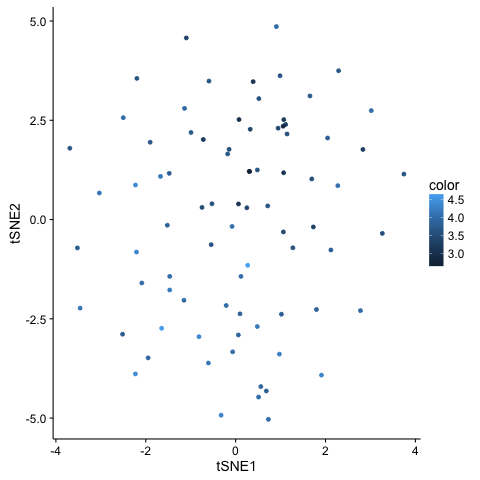

In [24]:
%%R -i color
qplot(x=res$Y[,1], y=res$Y[,2], color=color) + ylab('tSNE2') + xlab('tSNE1')

Instead of modelling the cell cycle, now try to model a differentiation factor (GO:0045064). What do you find?